In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.python.ops import rnn, rnn_cell

import seaborn as sns
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive


import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.backend import clear_session
from tensorflow.python.ops import rnn, rnn_cell

# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score

In [14]:
tf.keras.backend.clear_session()

# Bidirectional Reccursive Neural Networks

### Due to the poor accuracy results, It was decided to try bidirectional RNN

In [6]:
def build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units):
    # Number of features and timesteps
    num_features = input_shape[1]
    timesteps = input_shape[0]

    # Build the model
    model = models.Sequential([
        # First LSTM layer wrapped in Bidirectional
        layers.Bidirectional(
            layers.LSTM(n_hidden_units, return_sequences=True, dropout=0.25, recurrent_dropout=0.25,
                        kernel_regularizer=regularizers.l2(l2_lambda)),
            input_shape=(timesteps, num_features)
        ),

        # Second LSTM layer wrapped in Bidirectional
        layers.Bidirectional(
            layers.LSTM(n_hidden_units, dropout=0.25, recurrent_dropout=0.25,
                        kernel_regularizer=regularizers.l2(l2_lambda))
        ),

        # Dense layer for classification
        layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_lambda))
    ])

    return model


In [7]:

def test(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units):
    
    i = 1 #fold1 used for test

    # Define test set paths
    X_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_4sec_mfccs_13/3D_array.npy'
    Y_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_label/3D_array.npy'

    X_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+'_label/3D_array.npy'
    X_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+'_label/3D_array.npy'

    # Combine the validation paths
    X_val_paths = [X_val_path1, X_val_path2]
    Y_val_paths = [Y_val_path1, Y_val_path2]

    # # Define training set paths (all remaining folds)
    X_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+10)]
    Y_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+'_label/3D_array.npy' for j in range(i+3, i+10)]

    # Define test set paths
    X_test_path = f'UrbanSound8K/audio/fold{i}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_test_path = f'UrbanSound8K/audio/fold{i}_label/3D_array.npy'

    # Define validation set paths (wrapping around if i+2 > 10)
    X_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_label/3D_array.npy'
    X_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
    Y_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_label/3D_array.npy'

    # Combine the validation paths
    X_val_paths = [X_val_path1, X_val_path2]
    Y_val_paths = [Y_val_path1, Y_val_path2]

    # Define training set paths (all remaining folds)
    X_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+11)]
    Y_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_label/3D_array.npy' for j in range(i+3, i+11)]

    # Load the datasets from the paths
    X_test = np.load(X_test_path)
    Y_test = np.load(Y_test_path)


    X_val1 = np.load(X_val_path1)
    X_val2 = np.load(X_val_path2)
    Y_val1 = np.load(Y_val_path1)
    Y_val2 = np.load(Y_val_path2)

    X_train = [np.load(path) for path in X_train_paths]
    Y_train = [np.load(path) for path in Y_train_paths]


    # Find the minimum size among all folds
    min_size = min([X_test.shape[0], X_val1.shape[0], X_val2.shape[0]] + [x.shape[0] for x in X_train])

    # Resize the data of each fold to the minimum size
    X_test_resized = X_test[:min_size]
    Y_test_resized = Y_test[:min_size]

    X_val1_resized = X_val1[:min_size]
    Y_val1_resized = Y_val1[:min_size]

    X_val2_resized = X_val2[:min_size]
    Y_val2_resized = Y_val2[:min_size]

    X_train_resized = [x[:min_size] for x in X_train]
    Y_train_resized = [y[:min_size] for y in Y_train]


    # Combine the validation sets
    X_test = X_test_resized
    Y_test = Y_test_resized
    X_val = np.concatenate((X_val1_resized, X_val2_resized), axis=2)
    Y_val = np.concatenate((Y_val1_resized, Y_val2_resized), axis=2)
    X_train = np.concatenate((X_train_resized[0], X_train_resized[1], X_train_resized[2], X_train_resized[3], X_train_resized[4], X_train_resized[5], X_train_resized[6]), axis=2)
    Y_train = np.concatenate((Y_train_resized[0], Y_train_resized[1], Y_train_resized[2], Y_train_resized[3], Y_train_resized[4], Y_train_resized[5], Y_train_resized[6]), axis=2)

    X_test = X_test.transpose(2,1,0)
    Y_test = Y_test.transpose(2,1,0)
    X_val = X_val.transpose(2,1,0)
    Y_val = Y_val.transpose(2,1,0)
    X_train = X_train.transpose(2,1,0)
    Y_train = Y_train.transpose(2,1,0)

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Clear Previous Sessions
    clear_session()  


    # Call de neural network
    input_shape = (751, mfcc)
    num_classes = 10


    #Neural Network Initialization
    if nn_type == "bd_rnn":
        model = build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units)

    else:
        print("Introduce a valid neural network")




    # print The neural network's architecture
    model.summary() 

    # Define the optimizer
    optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum)

    #output layer
    model.add(layers.Dense(10, activation='softmax'))

    
    Y_train = np.squeeze(Y_train, axis=1)
    Y_val = np.squeeze(Y_val, axis=1)



    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    history = model.fit(

        #training dataset
        X_train,
        Y_train,

        epochs=n_epochs,  # Number of epochs
        batch_size=batch_size, # Number of samples per batch

        #validation dataset
        validation_data=(X_val, Y_val)
    )





    Y_train_classes = np.squeeze(Y_train).argmax(axis=-1) if Y_train.ndim == 3 else Y_train
    Y_val_classes = np.squeeze(Y_val).argmax(axis=-1) if Y_val.ndim == 3 else Y_val

    # Generate predictions
    Y_pred = model.predict(X_test)  # Predicted probabilities

    # Convert predictions to class labels
    Y_pred_classes = np.argmax(Y_pred, axis=-1)  # Convert probabilities to class labels

    # Flatten the one-hot encoded labels to 1D if they are 3D for Y_test
    Y_test_classes = np.squeeze(Y_test).argmax(axis=-1) if Y_test.ndim == 3 else Y_test


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

    # Evaluate the model
    scores = model.evaluate(X_test, np.squeeze(Y_test), verbose=0)
    print(f"Test accuracy for fold {i}:", scores[1])
    


    # Calculate precision and recall
    precision = precision_score(Y_test_classes, Y_pred_classes, average='macro')
    recall = recall_score(Y_test_classes, Y_pred_classes, average='macro')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")




    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()



    return scores[1], history 

### First Combination os Hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 751, 256)          145408    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 542218 (2.07 MB)
Trainable params: 542218 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
95/95 [==============================] - 1507s 16s/step - loss: 2.3712 - accuracy: 0.1307 - val_loss: 2.3615 - val_accuracy: 0.1418
Epoch 2/2


/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


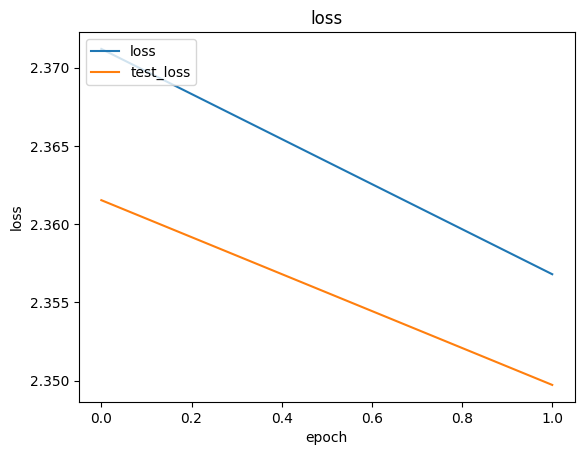

(0.145475372672081, <keras.src.callbacks.History at 0x1112a5460>)

In [8]:
n_epochs = 2 
batch_size = 64  
learning_rate = 0.001  
momentum = 0.9  
n_hidden_units = 128  
l2_lambda = 0.0001  

nn_type = "bd_rnn"
mfcc = 13

test(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

### Second Combination of Hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 751, 256)          145408    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 542218 (2.07 MB)
Trainable params: 542218 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
95/95 [==============================] - 2008s 21s/step - loss: 2.3780 - accuracy: 0.1156 - val_loss: 2.3726 - val_accuracy: 0.1103
Epoch 2/2


/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


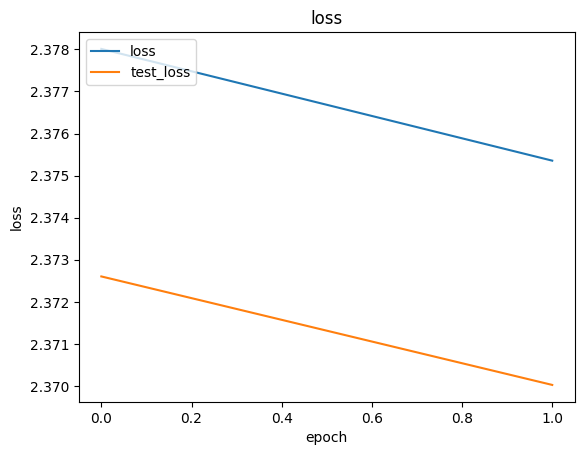

(0.11454753577709198, <keras.src.callbacks.History at 0x1114c5d60>)

In [9]:
n_epochs = 2 
batch_size = 64  
learning_rate = 0.0001  
momentum = 0.9  
n_hidden_units = 128  
l2_lambda = 0.0001  

nn_type = "bd_rnn"
mfcc = 13

test(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

In [17]:
def main(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units):
   
    # General Confusion Matrix
    confusion_matrix_accumulated = np.zeros((10, 10))
    accuracies = []

    for i in range(1, 11):

        # Define test set paths
        X_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_4sec_mfccs_13/3D_array.npy'
        Y_test_path = 'UrbanSound8K/audio/fold'+str(i)+'_label/3D_array.npy'

        X_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path1 = 'UrbanSound8K/audio/fold'+str((i+1-1) % 10 + 1)+'_label/3D_array.npy'
        X_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path2 = 'UrbanSound8K/audio/fold'+str((i+2-1) % 10 + 1)+'_label/3D_array.npy'

        # Combine the validation paths
        X_val_paths = [X_val_path1, X_val_path2]
        Y_val_paths = [Y_val_path1, Y_val_path2]

        # # Define training set paths (all remaining folds)
        X_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+f'_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+10)]
        Y_train_paths = ['UrbanSound8K/audio/fold'+str((j-1) % 10 + 1)+'_label/3D_array.npy' for j in range(i+3, i+10)]

        # Define test set paths
        X_test_path = f'UrbanSound8K/audio/fold{i}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_test_path = f'UrbanSound8K/audio/fold{i}_label/3D_array.npy'

        # Define validation set paths (wrapping around if i+2 > 10)
        X_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path1 = f'UrbanSound8K/audio/fold{((i+1-1) % 10 + 1)}_label/3D_array.npy'
        X_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy'
        Y_val_path2 = f'UrbanSound8K/audio/fold{((i+2-1) % 10 + 1)}_label/3D_array.npy'

        # Combine the validation paths
        X_val_paths = [X_val_path1, X_val_path2]
        Y_val_paths = [Y_val_path1, Y_val_path2]

        # Define training set paths (all remaining folds)
        X_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_4sec_mfccs_{mfcc}/3D_array.npy' for j in range(i+3, i+11)]
        Y_train_paths = [f'UrbanSound8K/audio/fold{((j-1) % 10 + 1)}_label/3D_array.npy' for j in range(i+3, i+11)]

        # Load the datasets from the paths
        X_test = np.load(X_test_path)
        Y_test = np.load(Y_test_path)


        X_val1 = np.load(X_val_path1)
        X_val2 = np.load(X_val_path2)
        Y_val1 = np.load(Y_val_path1)
        Y_val2 = np.load(Y_val_path2)

        X_train = [np.load(path) for path in X_train_paths]
        Y_train = [np.load(path) for path in Y_train_paths]

        
        # Find the minimum size among all folds
        min_size = min([X_test.shape[0], X_val1.shape[0], X_val2.shape[0]] + [x.shape[0] for x in X_train])

        # Resize the data of each fold to the minimum size
        X_test_resized = X_test[:min_size]
        Y_test_resized = Y_test[:min_size]

        X_val1_resized = X_val1[:min_size]
        Y_val1_resized = Y_val1[:min_size]

        X_val2_resized = X_val2[:min_size]
        Y_val2_resized = Y_val2[:min_size]

        X_train_resized = [x[:min_size] for x in X_train]
        Y_train_resized = [y[:min_size] for y in Y_train]


        # Combine the validation sets
        X_test = X_test_resized
        Y_test = Y_test_resized
        X_val = np.concatenate((X_val1_resized, X_val2_resized), axis=2)
        Y_val = np.concatenate((Y_val1_resized, Y_val2_resized), axis=2)
        X_train = np.concatenate((X_train_resized[0], X_train_resized[1], X_train_resized[2], X_train_resized[3], X_train_resized[4], X_train_resized[5], X_train_resized[6]), axis=2)
        Y_train = np.concatenate((Y_train_resized[0], Y_train_resized[1], Y_train_resized[2], Y_train_resized[3], Y_train_resized[4], Y_train_resized[5], Y_train_resized[6]), axis=2)

        X_test = X_test.transpose(2,1,0)
        Y_test = Y_test.transpose(2,1,0)
        X_val = X_val.transpose(2,1,0)
        Y_val = Y_val.transpose(2,1,0)
        X_train = X_train.transpose(2,1,0)
        Y_train = Y_train.transpose(2,1,0)


    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        # Clear Previous Sessions
        clear_session()  


        # Call de neural network
        input_shape = (751, mfcc)
        num_classes = 10

        #Neural Network Initialization
        if nn_type == "bd_rnn":
            model = build_rnn_model(input_shape, num_classes, l2_lambda, n_hidden_units)

        else:
            print("Introduce a valid neural network")


        # print The neural network's architecture
        model.summary() 
        
        optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum)

        #output layer
        model.add(layers.Dense(10, activation='softmax'))

        #fiz isto pq estava a dar erro e não sei porquê, mas funciona para rnn
        Y_train = np.squeeze(Y_train, axis=1)
        Y_val = np.squeeze(Y_val, axis=1)


        # Compile the model.
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )


        history = model.fit(

            #training dataset
            X_train,
            Y_train,

            epochs=n_epochs,  # Number of epochs
            batch_size=batch_size, # Number of samples per batch

            #validation dataset
            validation_data=(X_val, Y_val)
        )



    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Evaluate the model
        Y_train_classes = np.squeeze(Y_train).argmax(axis=-1) if Y_train.ndim == 3 else Y_train
        Y_val_classes = np.squeeze(Y_val).argmax(axis=-1) if Y_val.ndim == 3 else Y_val

        # Generate predictions
        Y_pred = model.predict(X_test)  # Predicted probabilities

        # Convert predictions to class labels
        Y_pred_classes = np.argmax(Y_pred, axis=-1)  # Convert probabilities to class labels

        # Flatten the one-hot encoded labels to 1D if they are 3D for Y_test
        Y_test_classes = np.squeeze(Y_test).argmax(axis=-1) if Y_test.ndim == 3 else Y_test

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)
        confusion_matrix_accumulated += conf_matrix

        # Evaluate the model, ensuring the Y_test used here matches the format expected by the model
        scores = model.evaluate(X_test, np.squeeze(Y_test), verbose=0)
        print(f"Test accuracy for fold {i}:", scores[1])


        # Calculate precision and recall
        precision = precision_score(Y_test_classes, Y_pred_classes, average='macro')
        recall = recall_score(Y_test_classes, Y_pred_classes, average='macro')

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        accuracies.append(scores[1])
        print(f"Test accuracy for fold {i}:", scores[1])


    print("General Confusion Matrix:")
    print(confusion_matrix_accumulated)

    print("Accuracies' Average:")
    print(np.mean(accuracies))

    print("Standard Deviation of the accuracies:")
    print(np.std(accuracies))

    # Bar plot to visualize the accuracies
    plt.bar(range(1, 11), accuracies)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Across Iterations')
    plt.show()

    # plot training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()

In [18]:
n_epochs = 2 
batch_size = 64  
learning_rate = 0.001  
momentum = 0.9  
n_hidden_units = 128  
l2_lambda = 0.0001  

nn_type = "bd_rnn"
mfcc = 13

main(nn_type, mfcc, n_epochs, batch_size, learning_rate, momentum, l2_lambda, n_hidden_units)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 751, 256)          145408    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 542218 (2.07 MB)
Trainable params: 542218 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
95/95 [==============================] - 1388s 14s/step - loss: 2.3712 - accuracy: 0.1156 - val_loss: 2.3655 - val_accuracy: 0.1335
Epoch 2/2


/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 751, 256)          145408    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 542218 (2.07 MB)
Trainable params: 542218 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
93/93 [==============================] - 949s 10s/step - loss: 2.3705 - accuracy: 0.1380 - val_loss: 2.3634 - val_accuracy: 0.1577
Epoch 2/2
2

/Users/larasousa/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 751, 256)          145408    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 542218 (2.07 MB)
Trainable params: 542218 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49/92 [==============>...............] - ETA: 10:07 - loss: 2.3707 - accuracy: 0.1164

KeyboardInterrupt: 